In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

% matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 8.0)
pd.set_option('display.precision',9)

In [103]:
df = pd.read_csv('./bw_data.csv')
df.drop(columns=['id'], inplace=True)
#df.drop(columns=['id'], inplace=True)
df = df[df.loc[:, 'ts'] != 'ts']
df.loc[:, 'bandwidth'] = pd.to_numeric(df.loc[:, 'bandwidth'], errors='coerce')
df['ts'] = pd.to_datetime(df['ts'], unit='s', utc=True)
df.head()

,ts,bandwidth
0,2018-02-14 02:32:13+00:00,56623520
1,2018-02-14 02:27:20+00:00,95733424
2,2018-02-14 01:41:11+00:00,52946496
3,2018-02-14 02:54:40+00:00,61887376
4,2018-02-14 03:31:43+00:00,48975776


In [104]:
## Make ts as index
df.set_index('ts', inplace=True)
df.sort_index(inplace=True)

In [105]:
df_week = df[(df.index.day > 6) & (df.index.day <= 7) & (df.index.month == 2)]

In [106]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

lag_acf = acf(df_week, nlags=60)
lag_pacf = pacf(df_week, nlags=30, method='ols')

Text(0.5,1,'Autocorrelation Function')

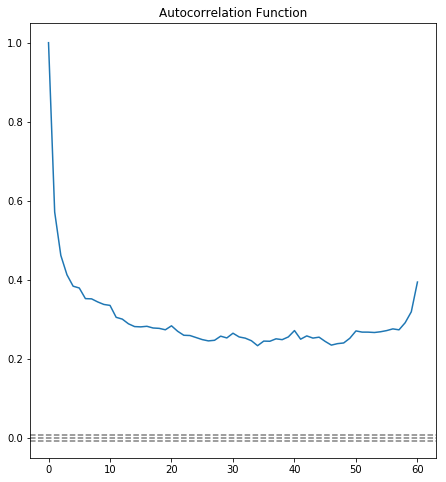

In [107]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_week)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_week)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

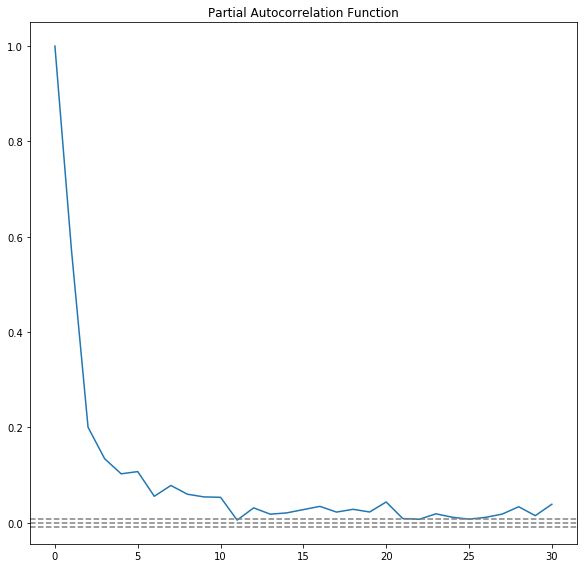

In [108]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_week)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_week)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# General explanation
Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. 
    Here the null hypothesis is that the TS is non-stationary. 
    The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 
    If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

In [109]:
## Dicky Fuller test the stationarity of time series.
# If data is not stationary then have to remove trend/seasnoality and fit the models on residuals.
    
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=30)
    rolstd = pd.rolling_std(timeseries, window=30)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:, 0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1) constant mean
2) constant variance
3) an autocovariance that does not depend on time.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).mean()
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).std()
  if __name__ == '__main__':


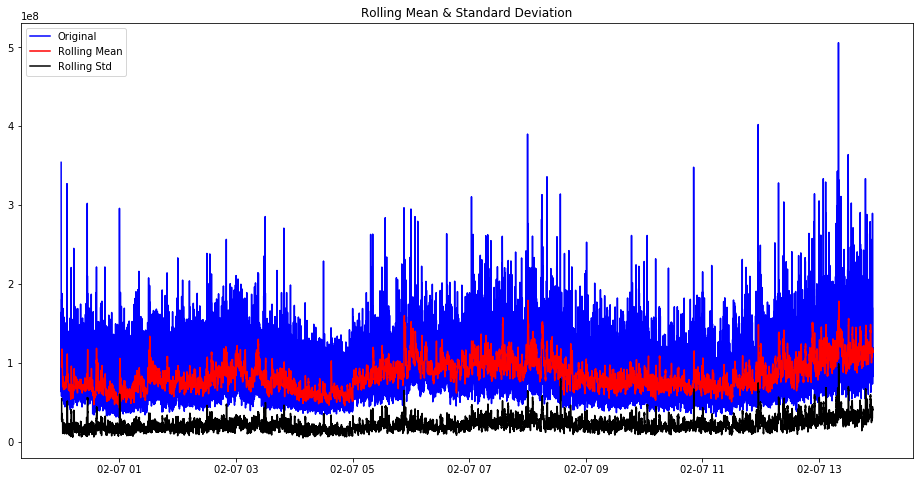

Results of Dickey-Fuller Test:
Test Statistic                -1.109985870e+01
p-value                        3.889766709e-20
#Lags Used                     5.700000000e+01
Number of Observations Used    4.994200000e+04
Critical Value (1%)           -3.430480945e+00
Critical Value (5%)           -2.861597875e+00
Critical Value (10%)          -2.566800805e+00
dtype: float64


In [110]:
test_stationarity(df_week)

# Test statistics is less then critical value, so reject null hypothesis.

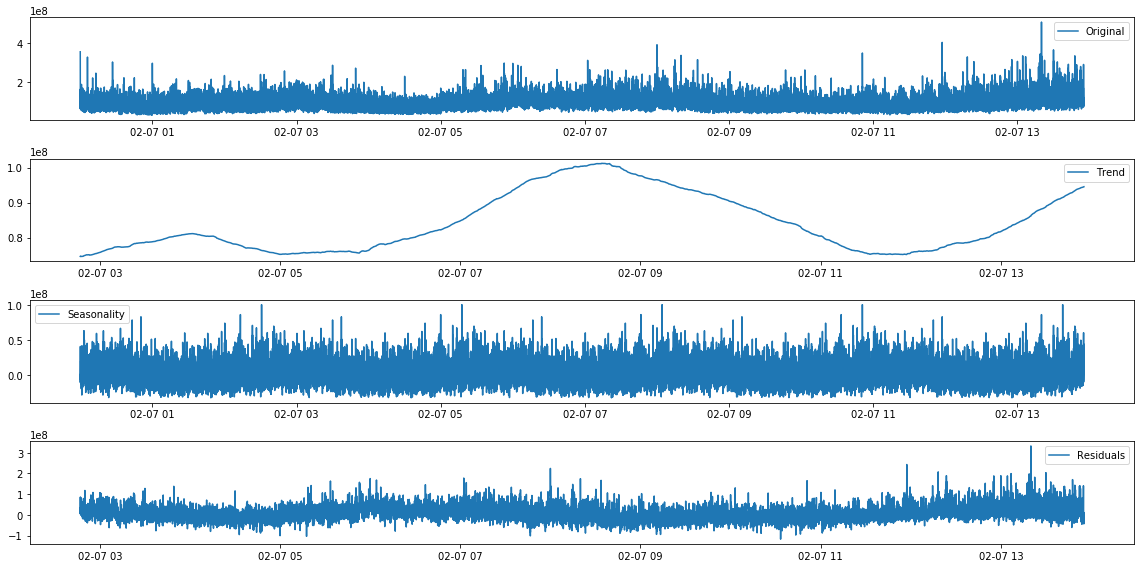

In [111]:
# Apply seasonal_decompose to the bus data and plot the result
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

decomposition = seasonal_decompose(df_week, model='additive', freq=10000, two_sided=False)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_week, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Autocorrelation Plot

Check if data related with respect to previous data or not. If it is around 0 then its random.

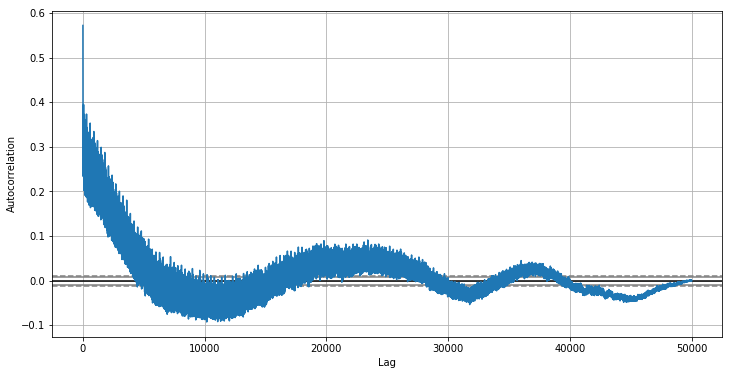

In [112]:
from pandas.plotting import autocorrelation_plot
fig,ax = plt.subplots(figsize=(12, 6))
autocorrelation_plot(df_week.loc[:, 'bandwidth'], ax=ax)

In [113]:
size = int(len(df_week) * 0.70)
train, test = df_week.iloc[0:size, :], df_week.iloc[size:len(df_week), :]

### The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1) Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable.

2) Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation.

3) Number of Differences (d): These are the number of nonseasonal differences

#### AR Model with 3 lags

In [18]:
#AR Model
from statsmodels.tsa.arima_model import ARIMA
train['bandwidth'] = train['bandwidth'].astype(float)

model_ar = ARIMA(train['bandwidth'], order=(3, 0, 0), freq="S", dates=train.index)  
#Fit AR model 
results_AR = model_ar.fit(disp=-1, method = 'css', trend='nc', solver='powell', max_iter = 1000) 

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Optimization terminated successfully.
         Current function value: 18.399681
         Iterations: 2
         Function evaluations: 80


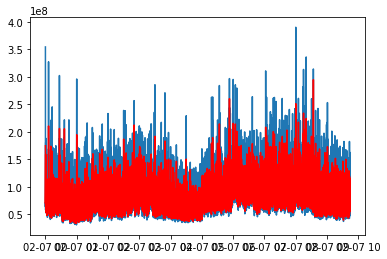

In [19]:
#Plot it
plt.plot(train)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_week)**2))

In [20]:
print('RSS: %.4f'% sum(((results_AR.fittedvalues-train['bandwidth']).dropna())**2))

RSS: 19709979624136257536.0000


#### MA Model with 3 lags

In [21]:
model_ma = ARIMA(train['bandwidth'], order=(0, 0, 3), freq="S", dates=train.index)  
#Fit AR model 
results_MA = model_ma.fit(disp=-1, method = 'css', trend='nc', solver='powell', max_iter = 1000) 

Optimization terminated successfully.
         Current function value: 18.869285
         Iterations: 3
         Function evaluations: 103


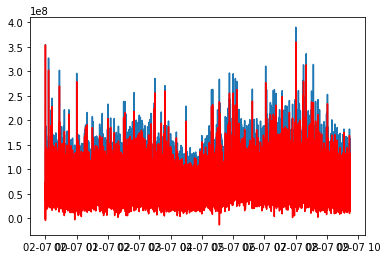

In [22]:
plt.plot(train)
plt.plot(results_MA.fittedvalues, color='red')

In [23]:
sse = sum(((results_MA.fittedvalues-train['bandwidth']).dropna())**2)
rmse = np.sqrt(sse/len(train['bandwidth']))
print('RSS: %.4f'% sse)
print('RMSE: %.4f'% rmse)

RSS: 50262777576521433088.0000
RMSE: 37895637.7348


### ARIMA model:  with 4 lags for AR and 3 for MA Model.

In [24]:
model_ar_ma = ARIMA(train['bandwidth'], order=(4, 0, 3), freq="S", dates=train.index)  
#Fit AR model 
results_AR_MA = model_ar_ma.fit(disp=-1, method = 'css', trend='nc', solver='powell', max_iter = 1000) 

Optimization terminated successfully.
         Current function value: 18.336244
         Iterations: 1
         Function evaluations: 75


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


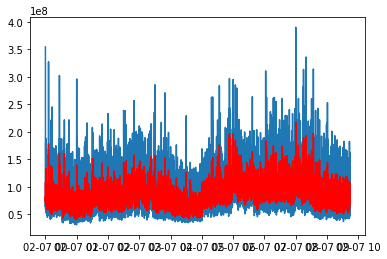

In [25]:
plt.plot(train)
plt.plot(results_AR_MA.fittedvalues, color='red')

In [26]:
print('RSS: %.4f'% sum(((results_AR_MA.fittedvalues-train['bandwidth']).dropna())**2))

RSS: 17378944249010604032.0000


In [27]:
pred = results_AR_MA.forecast(steps=len(test))[0]

In [49]:
history = [x for x in train['bandwidth']]
test_list = [x for x in test['bandwidth']]

## Predict and run the model on test set.

### Prediction using ARIMA(4,0,3)

In [50]:
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4, 0, 3), freq="S")
    model_fit = model.fit(disp=-1, method = 'css', trend='nc', solver='powell', max_iter = 1000) 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_list[t]
    history.append(obs)
    del model
    del model_fit
    #print('predicted=%f, expected=%f' % (yhat, obs))

Optimization terminated successfully.
         Current function value: 18.336244
         Iterations: 1
         Function evaluations: 75


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 18.336234
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336451
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336470
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336457
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336456
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336457
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336448
         Iterations: 1
         Function evaluations: 76
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.336359
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336347
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336333
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336330
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336321
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336313
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336307
         Iterations: 1
         Function evaluations: 76
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.336576
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336566
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336766
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336782
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336784
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336786
         Iterations: 1
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 18.336795
         Iterations: 1
         Function evaluations: 76
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.336930
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336920
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336907
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336893
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336879
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336872
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.336876
         Iterations: 1
         Function evaluations: 75
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.337603
         Iterations: 1
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 18.337625
         Iterations: 1
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 18.337614
         Iterations: 1
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 18.337611
         Iterations: 1
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 18.337599
         Iterations: 1
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 18.337586
         Iterations: 1
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 18.337587
         Iterations: 1
         Function evaluations: 74
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.337772
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337758
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337770
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337757
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337744
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337739
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337728
         Iterations: 1
         Function evaluations: 75
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.337803
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337793
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337779
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337775
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337763
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337776
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 18.337769
         Iterations: 1
         Function evaluations: 75
Optimization terminated successful

KeyboardInterrupt: 

Test MSE: 659398830127356.375


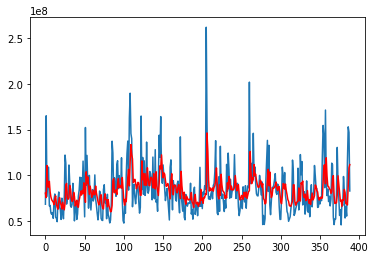

In [56]:
from sklearn.metrics import mean_squared_error

test_list_trimmed = test_list[0:389]
error = mean_squared_error(test_list_trimmed, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test_list_trimmed)
plt.plot(predictions, color='red')
plt.show()

In [80]:
history = [x for x in train['bandwidth']]
test_list = [x for x in test['bandwidth']]

predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1, 0, 1), freq="S")
    model_fit = model.fit(disp=-1, method = 'css', trend='nc', solver='powell', max_iter = 1000) 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_list[t]
    history.append(obs)
    del model
    del model_fit

Optimization terminated successfully.
         Current function value: 18.366750
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366741
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366931
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366934
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366920
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366911
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366924
         Iterations: 2
         Function evaluations: 55
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.366819
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366806
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366793
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366779
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366780
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366768
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.366758
         Iterations: 2
         Function evaluations: 55
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.367145
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367145
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367134
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367352
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367343
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367346
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367344
         Iterations: 2
         Function evaluations: 55
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.367458
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367443
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367429
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367415
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367401
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367387
         Iterations: 2
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 18.367387
         Iterations: 2
         Function evaluations: 55
Optimization terminated successful

KeyboardInterrupt: 

Test MSE: 631344413543430.125


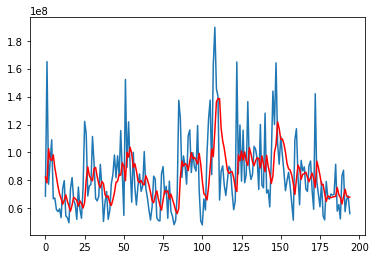

In [81]:
test_list_trimmed = test_list[0:len(predictions)]
error = mean_squared_error(test_list_trimmed, predictions)
print('Test RMSE: %.3f' % error)
# plot
plt.plot(test_list_trimmed)
plt.plot(predictions, color='red')
plt.show()

In [87]:
history = [x for x in train['bandwidth']]
test_list = [x for x in test['bandwidth']]

predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0, 0, 2), freq="S")
    model_fit = model.fit(disp=-1, method = 'css-mle', trend='nc', solver='powell', max_iter = 1000) 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_list[t]
    history.append(obs)
    del model
    del model_fit

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Optimization terminated successfully.
         Current function value: 19.016410
         Iterations: 1
         Function evaluations: 23


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Optimization terminated successfully.
         Current function value: 19.016396
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016521
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016529
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016543
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016581
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016585
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016601
         Iterations: 1
         Function evaluations: 23
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 19.016534
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016522
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016529
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016527
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016512
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016510
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016498
         Iterations: 1
         Function evaluations: 23
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 19.016526
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016523
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016613
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016619
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016672
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016661
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016658
         Iterations: 1
         Function evaluations: 23
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 19.016745
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016738
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016732
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016720
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016714
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016718
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016704
         Iterations: 1
         Function evaluations: 23
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 19.017009
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017032
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017019
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017009
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017024
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017012
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.016999
         Iterations: 1
         Function evaluations: 23
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 19.017150
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017149
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017159
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017147
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017141
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017153
         Iterations: 1
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 19.017139
         Iterations: 1
         Function evaluations: 23
Optimization terminated successful

KeyboardInterrupt: 

Test MSE: 2212655664388807.750


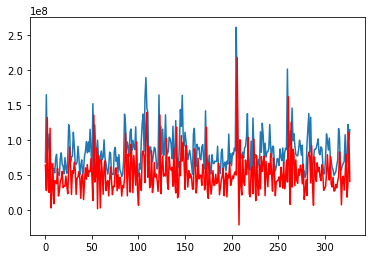

In [91]:
test_list_trimmed = test_list[0:len(predictions)]
error = mean_squared_error(test_list_trimmed, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test_list_trimmed)
plt.plot(predictions, color='red')
plt.show()

In [93]:
history = [x for x in train['bandwidth']]
test_list = [x for x in test['bandwidth']]

predictions = list()
for t in range(0, 300):
    model = ARIMA(history, order=(0, 0, 3), freq="S")
    model_fit = model.fit(disp=-1, method = 'css-mle', trend='nc', solver='powell', max_iter = 1000) 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_list[t]
    history.append(obs)
    del model
    del model_fit

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Optimization terminated successfully.
         Current function value: 18.868043
         Iterations: 1
         Function evaluations: 34


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Optimization terminated successfully.
         Current function value: 18.868037
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868171
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868217
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868231
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868256
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868242
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868228
         Iterations: 1
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.868074
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868060
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868054
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868072
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868058
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868045
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868037
         Iterations: 1
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.868009
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868002
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868121
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868146
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868183
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868169
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868218
         Iterations: 1
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.868409
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868395
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868395
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868389
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868376
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868377
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868363
         Iterations: 1
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 18.868839
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868856
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868842
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868832
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868845
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868838
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 18.868826
         Iterations: 1
         Function evaluations: 34
Optimization terminated successful

Test MSE: 1716788507158075.750


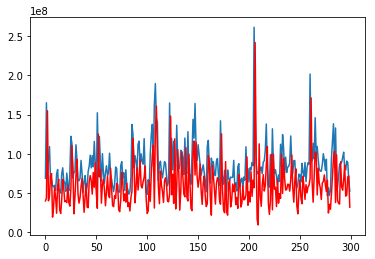

In [94]:
test_list_trimmed = test_list[0:len(predictions)]
error = mean_squared_error(test_list_trimmed, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test_list_trimmed)
plt.plot(predictions, color='red')
plt.show()

In [100]:
history = [x for x in train['bandwidth']]
test_list = [x for x in test['bandwidth']]

predictions = list()
for t in range(0, 200):
    model = ARIMA(history, order=(2, 0, 0), freq="S")
    model_fit = model.fit(disp=-1, method = 'css-mle', trend='nc', solver='powell', max_iter = 1000) 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_list[t]
    history.append(obs)
    del model
    del model_fit

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Optimization terminated successfully.
         Current function value: 18.427863
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Optimization terminated successfully.
         Current function value: 18.427852
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428049
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428088
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428079
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428079
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428091
         Iterations: 9
         Function evaluations: 11
  

Optimization terminated successfully.
         Current function value: 18.427858
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.427849
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.427871
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428042
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428040
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428029
         Iterations: 9
         Function evaluations: 11
  

Optimization terminated successfully.
         Current function value: 18.427891
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.427905
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.427913
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.427932
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.427920
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.427914
         Iterations: 9
         Function evaluations: 11
  

Optimization terminated successfully.
         Current function value: 18.428466
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428546
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428532
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428554
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428572
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428584
         Iterations: 9
         Function evaluations: 11
  

Optimization terminated successfully.
         Current function value: 18.428492
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428479
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428467
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428456
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428442
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 18.428472
         Iterations: 9
         Function evaluations: 11
  

Test MSE: 718100699505397.750


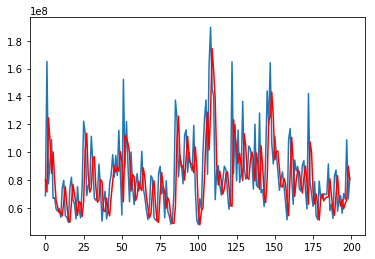

In [101]:
test_list_trimmed = test_list[0:len(predictions)]
error = mean_squared_error(test_list_trimmed, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test_list_trimmed)
plt.plot(predictions, color='red')
plt.show()